# Group Assignment - Computational Finance

**Professor**: N. Borri

**Academic Year**: 2023/2024

**Group Members**: Demetrio Francesco Cardile (267281); Andrea Magri (270401); Alessandro Vittorio Natoli (264481)

In the next sections, we will be implementing an investment strategy inspired by the legendary Warren Buffett. Our project is based on the influential paper "Buffett's Alpha" by Frazzini, Kabiller, and Pedersen (FKP, 2018), published in the Financial Analysts Journal. Through computational analysis, we aim to distill Buffett's investment principles outlined in the paper and create a strategy that mirrors his success in financial markets.

In [1]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import scipy.optimize as sco
from sklearn.model_selection import train_test_split
import seaborn as sns

# Task 1

Start by importing the risk factors from the AQR website. For each factor, use the
equity column USA and data at monthly frequency

In [2]:
# Path to your Excel file
file_path = 'Betting Against Beta Equity Factors Monthly.xlsx'

# Load the Excel file
xl = pd.ExcelFile(file_path)

# Initialize an empty DataFrame for the merged data
merged_df = pd.DataFrame()

# List of sheet names to process
sheets_to_process = ['BAB Factors', 'MKT', 'SMB', 'HML FF', 'UMD', 'RF']
    
   # Process each sheet and merge into a single DataFrame
for sheet_name in sheets_to_process:
    header_row = 18  # Default header row for most sheets
    column_name = 'USA'  # Default column name for USA data
    
    if sheet_name == 'RF':
        # Special handling for 'RF' sheet
        header_row = 18
        column_name = 'Risk Free Rate'  # Different column name for 'RF'
        #print("the column name is ", column_name)
    # Load the sheet with identified header row
    df = pd.read_excel(xl, sheet_name=sheet_name, header=header_row)
    # Check if the specific column exists in the dataframe
    #if sheet_name == 'RF':
        #print(df.columns)
    if column_name in df.columns:
        #print(column_name)
        # Select 'DATE' and the specific column
        df = df[['DATE', column_name]].copy()
        
        # Convert 'DATE' from object to datetime64
        df['DATE'] = pd.to_datetime(df['DATE'])
        
        # Rename the specific column to match the sheet name
        df.rename(columns={column_name: sheet_name}, inplace=True)
        
        # Merge the current data frame into the main merged DataFrame
        if merged_df.empty:
            merged_df = df  # if merged_df is empty, initialize it
        else:
            merged_df = pd.merge(merged_df, df, on='DATE', how='outer')

# Print the head of the merged DataFrame to check the data
print(merged_df.head())

        DATE  BAB Factors       MKT       SMB    HML FF       UMD      RF
0 1930-12-31    -0.000558 -0.076272 -0.028127 -0.053022  0.125667  0.0014
1 1931-01-31    -0.022446  0.060670  0.032424  0.072300 -0.110838  0.0015
2 1931-02-28    -0.077423  0.105313  0.060026 -0.028181 -0.123548  0.0004
3 1931-03-31     0.029235 -0.062775  0.038354 -0.044958  0.084249  0.0013
4 1931-04-30    -0.012986 -0.095481 -0.023787 -0.023853  0.104019  0.0008


In [3]:
# Path to your Excel file
file_path = 'Quality Minus Junk Factors Monthly.xlsx'

# Load the Excel file
xl = pd.ExcelFile(file_path)

# Initialize an empty DataFrame for the merged data
qmj_df = pd.DataFrame()

# List of sheet names to process
sheets_to_process = ['QMJ Factors']
    
   # Process each sheet and merge into a single DataFrame
for sheet_name in sheets_to_process:
    header_row = 18  # Default header row for most sheets
    column_name = 'USA'  # Default column name for USA data
    
    if sheet_name == 'RF':
        # Special handling for 'RF' sheet
        header_row = 18
        column_name = 'Risk Free Rate'  # Different column name for 'RF'
        #print("the column name is ", column_name)
    # Load the sheet with identified header row
    df = pd.read_excel(xl, sheet_name=sheet_name, header=header_row)
    # Check if the specific column exists in the dataframe
    #if sheet_name == 'RF':
        #print(df.columns)
    if column_name in df.columns:
        #print(column_name)
        # Select 'DATE' and the specific column
        df = df[['DATE', column_name]].copy()
        
        # Convert 'DATE' from object to datetime64
        df['DATE'] = pd.to_datetime(df['DATE'])

        
        # Rename the specific column to match the sheet name
        df.rename(columns={column_name: sheet_name}, inplace=True)
        
        # Merge the current data frame into the main merged DataFrame
        if qmj_df.empty:
            qmj_df = df  # if merged_df is empty, initialize it
        else:
            qmj_df = pd.merge(qmj_df, df, on='DATE', how='outer')

# Print the head of the merged DataFrame to check the data
print(qmj_df.head())

        DATE  QMJ Factors
0 1957-07-31     0.011154
1 1957-08-31     0.004877
2 1957-09-30     0.007009
3 1957-10-31     0.002708
4 1957-11-30    -0.008971


In [4]:
merged_df = pd.merge(merged_df, qmj_df, on='DATE', how='inner')
merged_df.head()

,DATE,BAB Factors,MKT,SMB,HML FF,UMD,RF,QMJ Factors
0,1957-07-31,0.010207,0.005991,-0.006215,-0.003888,-0.002344,0.0030,0.011154
1,1957-08-31,0.034536,-0.051289,-0.001589,0.005218,0.005306,0.0025,0.004877
2,1957-09-30,0.037960,-0.059870,0.008881,0.010078,0.006853,0.0026,0.007009
3,1957-10-31,0.011091,-0.043083,-0.020106,-0.013024,0.019335,0.0029,0.002708
4,1957-11-30,0.015133,0.022757,0.001448,-0.012298,0.026341,0.0028,-0.008971


# Task 2

Import from Bloomberg, or Datastream, or Yahoo Finance, the market price data on Berkshire’s Hathaway, Buffett’s company. Consider 12/31/1999–last available month.

**Note**: We will not download monthly data from YFinance, as one may guess. The reason is that monthly data (from *yfinance* library) are collected the first day of each month. Instead, the monthly risk factors (returns) dowloaded above (from *Excel* files) are collected the last day of each month. Hence, there is no possibilty to merge the data according to this strategy.

Instead, we download Berkshire's daily data, such that we will be able to combine the two dataframes (BRK-B data and risk factors) at a later stage without any problem. Then, we will compute monthly Berkshire returns by applying the *pct_change()* function to the column containing Berkshire Adjusted Closing prices. In this way, we will precisely compute Berkshire monthly returns.

In [5]:
stocks_df = yf.download("BRK-B", 
                      start='1999-12-31', 
                      end='2024-03-31', 
                      progress=False
                      #interval = '1mo' #need daily to merge later (monthly data was pickedat different times)
)['Adj Close']
stocks_df = pd.DataFrame(stocks_df)
stocks_df = stocks_df.reset_index()
#stocks_df['Date'] = pd.to_datetime(stocks_df['Date']).dt.strftime('%Y%m%d').astype(float)
stocks_df = stocks_df.rename(columns={ 'Adj Close': 'BRK-B'})
stocks_df.info()
stocks_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6099 entries, 0 to 6098
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6099 non-null   datetime64[ns]
 1   BRK-B   6099 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 95.4 KB


,Date,BRK-B
0,1999-12-31,36.599998
1,2000-01-03,35.299999
2,2000-01-04,34.080002
3,2000-01-05,34.639999
4,2000-01-06,36.080002


# Task 3

Report summary statistics on factors returns, as well as Berkshire’s returns. You can choose
the stats you deem more relevant (i.e., mean, SD, skewness, etc.). Comment briefly these
results.

In [6]:
#Risk Factors' Returns
combined_risk_factor = merged_df.drop(['RF'], axis=1)  # Risk-free rate removed

In [7]:
merged_df.rename(columns={'DATE': 'Date'}, inplace=True)  # Rename the column in merged_df
combined_data = pd.merge(merged_df, stocks_df, on='Date', how='inner') # -> use this dataframe for plots and corr matrix
combined_data.dropna(inplace=True)
combined_data['BRK-B Returns']  = combined_data['BRK-B'].pct_change()
combined_data.dropna(inplace=True)
combined_data['BRK-B Risk Premium'] = combined_data['BRK-B Returns'] - combined_data['RF']
#combined_data.drop(['BRK-B Returns'], axis=1, inplace=True)
combined_data.drop(['BRK-B'], axis=1, inplace=True)
combined_data.head()



,Date,BAB Factors,MKT,SMB,HML FF,UMD,RF,QMJ Factors,BRK-B Returns,BRK-B Risk Premium
1,2000-01-31,-0.002048,-0.042145,0.050176,-0.000573,0.012701,0.004308,-0.027291,-0.100546,-0.104855
2,2000-02-29,-0.134174,0.027377,0.127406,-0.084274,0.170105,0.004608,-0.066672,-0.125152,-0.129760
3,2000-03-31,0.001288,0.053077,-0.097396,0.013317,-0.049388,0.004683,0.045559,0.263889,0.259206
4,2000-05-31,0.060508,-0.045907,-0.043369,0.028036,-0.072868,0.004717,0.030251,0.036264,0.031547
5,2000-06-30,-0.101337,0.047920,0.080917,-0.078898,0.142324,0.004567,-0.028912,-0.066808,-0.071375


In [11]:
# Calculate summary statistics for returns excluding the 'Date' column (DEMETRIO)
returns_summary = combined_data['BRK-B Risk Premium'].agg(['mean', 'std', 'skew', 'kurt'])

# Calculate summary statistics for risk factors excluding the 'Date' column
risk_factors_summary = combined_risk_factor.drop(columns=['DATE']).agg(['mean', 'std', 'skew', 'kurt'])

# Calculate VaR at 5% for returns excluding the 'Date' column
VaR_5_returns = combined_data['BRK-B Risk Premium'].quantile(0.05)

# Calculate VaR at 5% for risk factors excluding the 'Date' column
VaR_5_risks = combined_risk_factor.drop(columns=['DATE']).quantile(0.05)

# Print the summary statistics excluding the 'Date' column
print("Berkshire's Monthly Returns Summary:")
print(returns_summary)
print("\nRisk Factors' Monthly Returns Summary:")
print(risk_factors_summary)

# Print VaR at 5% excluding the 'Date' column
print("\nValue at Risk (5% level) for Berkshire's Monthly Returns:")
print(VaR_5_returns)
print("\nValue at Risk (5% level) for Risk Factors' Monthly Returns:")
print(VaR_5_risks)

Berkshire's Monthly Returns Summary:
mean    0.012080
std     0.059647
skew    0.137477
kurt    2.279814
Name: BRK-B Risk Premium, dtype: float64

Risk Factors' Monthly Returns Summary:
      BAB Factors       MKT       SMB    HML FF        UMD  QMJ Factors
mean     0.007998  0.005658  0.001134  0.002359   0.006688     0.003638
std      0.031672  0.044506  0.026849  0.027320   0.040243     0.022479
skew    -0.449859 -0.517095  0.294805  0.138181  -1.541830     0.086907
kurt     4.411794  1.787490  1.400184  2.191976  11.013845     2.523716

Value at Risk (5% level) for Berkshire's Monthly Returns:
-0.08140463632106146

Value at Risk (5% level) for Risk Factors' Monthly Returns:
BAB Factors   -0.041228
MKT           -0.072592
SMB           -0.038066
HML FF        -0.038141
UMD           -0.058560
QMJ Factors   -0.030551
Name: 0.05, dtype: float64


The table provided summarizes statistical measures and risk assessments related to Berkshire Hathaway's monthly returns and various risk factors' monthly returns, along with the computed Value at Risk (VaR) for monthly returns.

##### Berkshire's Monthly Returns Summary:
- Mean: The average monthly return is 1.208%, indicating a relatively high average performance.
- Standard Deviation (std): The standard deviation is 5.9647%, which shows an average volatility in the monthly returns.
- Skewness (skew): The positive skewness (0.137477) suggests that the return distribution is slightly skewed to the right, meaning there are more frequent higher returns than lower ones.
- Kurtosis (kurt): The kurtosis value of 2.79814 indicates a leptokurtic distribution, suggesting that the returns have fatter tails and a sharper peak than the normal distribution, which implies a higher risk of extreme returns.
##### Risk Factors' Monthly Returns Summary:
This section details the statistical measures for various market risk factors: BAB, MKT, SMB, HML FF, UMD, and QMJ Factors.
Means range from 0.006568 for MKT to 0.06688 for UMD, showing different average returns for these factors.
Standard Deviations also vary widely, highlighting different levels of volatility across these factors.
Skewness values vary from significant negative skew (-1.541830 for HML FF) to positive skew, indicating different shapes of distribution tails for these factors.
Kurtosis values indicate a range of tail risk, with extremely high kurtosis for UMD (11.013845), suggesting a very high risk of extreme returns.
##### Value at Risk (VaR) Analysis:
Berkshire's Monthly Returns VaR: At a 5% level, the VaR is -8.14%, indicating that there is a 5% chance that Berkshire's monthly losses could exceed 8.14%.
Risk Factors' Monthly Returns VaR: Shows the potential loss for each risk factor at a 5% confidence level. For instance, the VaR for MKT is -7.27592%, indicating a 5% chance that the monthly returns could fall below this value.
Overall, these results are crucial for risk management, providing insights into the volatility, distribution characteristics, and risk levels associated with Berkshire Hathaway's investments and various market factors.

In [12]:
combined_data.head()

,Date,BAB Factors,MKT,SMB,HML FF,UMD,RF,QMJ Factors,BRK-B Returns,BRK-B Risk Premium
1,2000-01-31,-0.002048,-0.042145,0.050176,-0.000573,0.012701,0.004308,-0.027291,-0.100546,-0.104855
2,2000-02-29,-0.134174,0.027377,0.127406,-0.084274,0.170105,0.004608,-0.066672,-0.125152,-0.129760
3,2000-03-31,0.001288,0.053077,-0.097396,0.013317,-0.049388,0.004683,0.045559,0.263889,0.259206
4,2000-05-31,0.060508,-0.045907,-0.043369,0.028036,-0.072868,0.004717,0.030251,0.036264,0.031547
5,2000-06-30,-0.101337,0.047920,0.080917,-0.078898,0.142324,0.004567,-0.028912,-0.066808,-0.071375


## Enhancing visualization: some useful plots

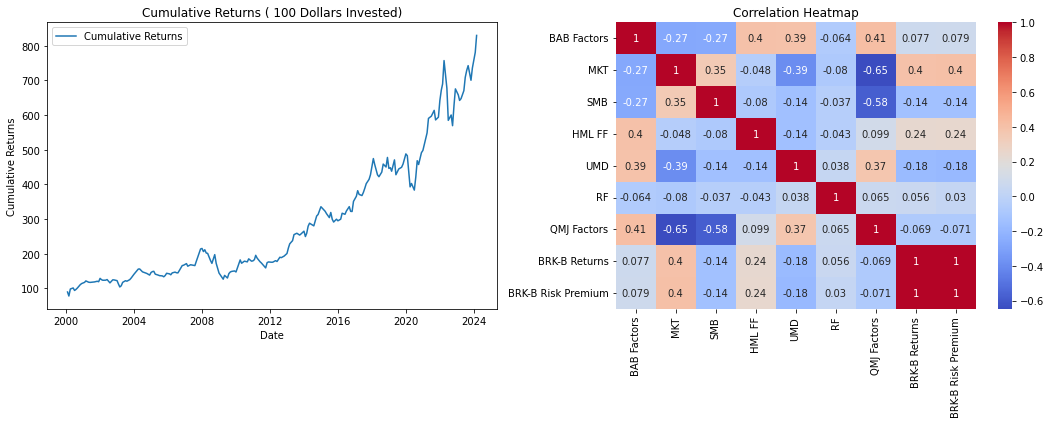

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

combined_data_copy = combined_data.copy()
combined_data_copy['Date'] = pd.to_datetime(combined_data['Date'])
combined_data_copy.set_index('Date', inplace=True)

# Calculate cumulative returns
cumulative_returns = pd.DataFrame()
cumulative_returns['Cumulative Returns'] = (1 + combined_data_copy['BRK-B Risk Premium']).cumprod() * 100

# Create a figure and axis object with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot cumulative returns on the left subplot
axs[0].plot(cumulative_returns.index, cumulative_returns['Cumulative Returns'])
axs[0].set_title('Cumulative Returns ( 100 Dollars Invested)')
axs[0].legend(cumulative_returns.columns)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Cumulative Returns')

# Plot heatmap on the right subplot
sns.heatmap(combined_data.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm', ax=axs[1])
axs[1].set_title('Correlation Heatmap')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show plot
plt.show()



The plot on the left hand side shows the evolution of a 100$ investment in Berkshire (BRK-B) undertaked in 2000. The performance, as expected, is definitely stunning. Among the main contributors to Buffet's success is definitely **leverage**, as discussing by FKP in the paper mentioned upon (recall the investigation of *credit rating* and *insurance float* 's impact on low cost of financing).

Instead, the heatmap on the right hand side shows the correlation among risk factors. It seems that most of the factors show low correlation, besides some exceptions such as *MKT* and *QMJ*, *SMB* and *QMJ*. However, we cannot draw any conclusion simply from this, as *correlation does not imply causation*. Notice that diagonal entries of the correlation matrix are all 1, which is obvious since they display correlation between the same variable. However, the red region on the bottom-right corner is not an anomaly, but a consequence of displaying both BRK-B returns and BRK-B risk premia (hence returns adjusted for Rf) in the same plot.

# Task 4

Compute the monthly (annualized) Sharpe ratio and Information ratio for Berkshire. Comment
the results. What is the Sharpe ratio of the US market in the same period? Provide also a
one line definition of information ratio

In [14]:
combined_data.head()

,Date,BAB Factors,MKT,SMB,HML FF,UMD,RF,QMJ Factors,BRK-B Returns,BRK-B Risk Premium
1,2000-01-31,-0.002048,-0.042145,0.050176,-0.000573,0.012701,0.004308,-0.027291,-0.100546,-0.104855
2,2000-02-29,-0.134174,0.027377,0.127406,-0.084274,0.170105,0.004608,-0.066672,-0.125152,-0.129760
3,2000-03-31,0.001288,0.053077,-0.097396,0.013317,-0.049388,0.004683,0.045559,0.263889,0.259206
4,2000-05-31,0.060508,-0.045907,-0.043369,0.028036,-0.072868,0.004717,0.030251,0.036264,0.031547
5,2000-06-30,-0.101337,0.047920,0.080917,-0.078898,0.142324,0.004567,-0.028912,-0.066808,-0.071375


In [15]:
# monthly std of the returns
rets_std_monthly = combined_data['BRK-B Risk Premium'].std()

# Convert to DataFrame
df = combined_data.copy()

# Calculate monthly returns for BRK-B and MKT (using the last day of the month closing price)
df['MKT_returns'] = df['MKT'] 

# Drop the first row due to NaN values from pct_change()
df = df.dropna()

# Calculate annualized Sharpe ratio for BRK-B and MKT
annual_factor = 12  # Monthly data

brk_sharpe_ratio = ((df['BRK-B Risk Premium'].mean()) / rets_std_monthly )* (annual_factor**0.5)
mkt_sharpe_ratio = ((df['MKT_returns'].mean()) / df['MKT_returns'].std()) * (annual_factor**0.5) #the MKT Returns is already excess return

# Calculate excess returns
df['Excess_BRK-B'] = df['BRK-B Risk Premium']
df['Excess_MKT'] = df['MKT']

# OLS regression
X = sm.add_constant(df['Excess_MKT'])  # Adding a constant for the intercept
model = sm.OLS(df['Excess_BRK-B'], X)
results = model.fit()

# Intercept (alpha) and standard deviation of residuals
alpha = results.params['const']
residual_std = results.resid.std()

# Information Ratio
information_ratio = alpha / residual_std

# Output the results
print(f"Intercept (Alpha): {alpha}")
print(f"Standard Deviation of Residuals: {residual_std}")
print(f"Information Ratio: {information_ratio}")
print("The Sharpe Ratio for BRK-B is: ", brk_sharpe_ratio)
print("The Sharpe Ratio for MKT is: ", mkt_sharpe_ratio)

Intercept (Alpha): 0.008788947298974035
Standard Deviation of Residuals: 0.05461954149420572
Information Ratio: 0.16091213984113004
The Sharpe Ratio for BRK-B is:  0.7015509022603559
The Sharpe Ratio for MKT is:  0.4756071550805039


The *Information Ratio* is described as the ratio between the intercept in a repgression of monthly excess returns on monthly market excess return and the standard deviation of the residuals (the error term of the regression that we want to minimize when performing OLS regressions). More specifically, the Information Ratio (IR) gauges how well a portfolio performs against its benchmark, considering risk. A higher IR indicates better performance, with positive values showing outperformance and negative values indicating underperformance. Finally, below are some comments concerning the results above:

- Intercept (Alpha): The intercept value represents the excess return of Berkshire (BRK-B) that is not explained by the market's excess returns. In this case, the intercept or alpha is 0.0088, indicating that Berkshire's excess returns are higher than what would be expected based solely on market movements.
- Standard Deviation of Residuals: This value (0.0546) indicates the volatility or variability of the residuals, which are the differences between the actual excess returns of Berkshire and the excess returns predicted by the regression model. A lower standard deviation suggests less variability in the residuals.
- Information Ratio: The Information Ratio (IR) measures the risk-adjusted performance of Berkshire relative to the market. An IR of 0.1609 indicates that Berkshire's excess returns, adjusted for risk, are approximately 0.1609 times its standard deviation of residuals. This suggests that Berkshire has been able to generate excess returns compared to the market, considering the level of risk taken.
- Sharpe Ratio for BRK-B: The Sharpe Ratio measures the risk-adjusted return of an investment. A Sharpe Ratio of 0.7016 for Berkshire indicates how much excess return it generates for each unit of total risk (standard deviation of returns).
- Sharpe Ratio for MKT: Similarly, the Sharpe Ratio for the market (MKT) is 0.4756, reflecting its risk-adjusted return.

Overall, based on these metrics, Berkshire (BRK-B) appears to have a positive alpha, but considering its order of magnitude (very low), we cannot conclude that Berkshire outperformed the market. However, its information Ratio and Sharpe Ratio indicate favorable risk-adjusted performance compared to the market.

# Task 5

Estimate a multivariate regression
Ret = α + β1Mktt + β2SMBt + β3HMLt + ...
... β4UMDt + β5BABt + β6QMJt + εt
and comment your results. In particular, comments on the sign and significance of the
estimates for the βs, the regression R2, etc.

In [16]:
combined_data.head()

,Date,BAB Factors,MKT,SMB,HML FF,UMD,RF,QMJ Factors,BRK-B Returns,BRK-B Risk Premium
1,2000-01-31,-0.002048,-0.042145,0.050176,-0.000573,0.012701,0.004308,-0.027291,-0.100546,-0.104855
2,2000-02-29,-0.134174,0.027377,0.127406,-0.084274,0.170105,0.004608,-0.066672,-0.125152,-0.129760
3,2000-03-31,0.001288,0.053077,-0.097396,0.013317,-0.049388,0.004683,0.045559,0.263889,0.259206
4,2000-05-31,0.060508,-0.045907,-0.043369,0.028036,-0.072868,0.004717,0.030251,0.036264,0.031547
5,2000-06-30,-0.101337,0.047920,0.080917,-0.078898,0.142324,0.004567,-0.028912,-0.066808,-0.071375


In [17]:
# Define the dependent variable
df = combined_data.copy()
y = df['BRK-B Risk Premium']

# Define the independent variables
X = df[['MKT', 'SMB', 'HML FF', 'UMD', 'BAB Factors', 'QMJ Factors']]
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     BRK-B Risk Premium   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     15.48
Date:                Fri, 03 May 2024   Prob (F-statistic):           1.50e-14
Time:                        18:05:53   Log-Likelihood:                 328.44
No. Observations:                 206   AIC:                            -642.9
Df Residuals:                     199   BIC:                            -619.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0062      0.004      1.662      


This table presents the results of an Ordinary Least Squares (OLS) regression analysis that models Berkshire Hathaway's Risk Premium (BRK-B Risk Premium) based on various market factors. Here are the key points to consider:

##### Coefficient Estimates and Significance:
- Constant (const): Coefficient is 0.0062, not statistically significant with a p-value of 0.098, suggesting the model intercept does not significantly differ from zero in the context of this model.
- Market Factor (MKT): Has a positive coefficient of 0.7369 and is highly significant (p-value = 0.000). This indicates a strong positive relationship with Berkshire's risk premium, suggesting that increases in the market factor are associated with increases in Berkshire’s premium.
- Small Minus Big (SMB): Coefficient is -0.4880, significant (p-value = 0.001), indicating a negative relationship. This suggests that smaller stocks minus bigger stocks negatively influence Berkshire's premium.
- High Minus Low (HML FF): Negative coefficient of -0.4045 with a p-value of 0.002, showing a significant negative relationship, indicating that value stocks (high book-to-market) negatively influence Berkshire's premium.
- Up Minus Down (UMD): Not significant with a p-value of 0.842, indicating that momentum factors (recent winners minus losers) do not significantly impact the risk premium.
- Betting Against Beta (BAB) Factors: Coefficient of 0.0500 but not statistically significant (p-value = 0.665), suggesting no significant influence on Berkshire’s risk premium.
- Quality Minus Junk (QMJ) Factors: Coefficient of 0.2923, not statistically significant (p-value = 0.119), indicating that quality factors do not significantly impact Berkshire’s premium.
##### Model Fit:
- R-squared: 0.318, which means that about 31.8% of the variance in Berkshire's risk premium is explained by the model. This is a moderate fit, suggesting that while the model captures a significant portion of variability, there is still a lot of variation that is not explained by these factors.
- Adjusted R-squared: 0.298, slightly lower than the R-squared, accounting for the number of predictors in the model. This value suggests that the independent variables provide a reasonable but not comprehensive explanation of the dependent variable.

# Task 6

Finally, construct your Buffett-style replica following the same steps specified in the slides.
Refer to the paper for further details. Comment your results

In [18]:
combined_data.head()

,Date,BAB Factors,MKT,SMB,HML FF,UMD,RF,QMJ Factors,BRK-B Returns,BRK-B Risk Premium
1,2000-01-31,-0.002048,-0.042145,0.050176,-0.000573,0.012701,0.004308,-0.027291,-0.100546,-0.104855
2,2000-02-29,-0.134174,0.027377,0.127406,-0.084274,0.170105,0.004608,-0.066672,-0.125152,-0.129760
3,2000-03-31,0.001288,0.053077,-0.097396,0.013317,-0.049388,0.004683,0.045559,0.263889,0.259206
4,2000-05-31,0.060508,-0.045907,-0.043369,0.028036,-0.072868,0.004717,0.030251,0.036264,0.031547
5,2000-06-30,-0.101337,0.047920,0.080917,-0.078898,0.142324,0.004567,-0.028912,-0.066808,-0.071375


In [19]:
from statsmodels.api import OLS, add_constant

# Step 1: Market Exposure
df = combined_data.copy()
X = add_constant(df['MKT'])  # Market returns with intercept
y = df['BRK-B Risk Premium']  # BRK-A returns
model = OLS(y, X).fit()
beta_buffett = model.params['MKT']

# Step 2: Active Returns Calculation
df['Active_Returns'] = df['BRK-B Returns'] - beta_buffett * df['MKT']
X2 = df[[ 'MKT', 'SMB', 'HML FF', 'UMD', 'BAB Factors', 'QMJ Factors']]
X2 = add_constant(X2)
model2 = OLS(df['Active_Returns'], X2).fit()

# Step 3: Return from Active Selection
df['Rt_Active'] = (model2.params * X2).sum(axis=1)

# Step 4: Rescale Active Returns
sigma_idiosyncratic = np.std(model.resid)
sigma_active = np.std(df['Rt_Active'])
scaling_factor = sigma_idiosyncratic / sigma_active
df['Rt_Active_Adjusted'] = df['Rt_Active'] * scaling_factor

# Step 5: Buffett-Style Systematic Replica
df['R_Buffett_Style'] = df['RF'] + beta_buffett * df['MKT'] + df['Rt_Active_Adjusted']


# Output results and comments
print(df[['Date', 'R_Buffett_Style']].head())
model2.summary()


        Date  R_Buffett_Style
1 2000-01-31        -0.098503
2 2000-02-29        -0.237457
3 2000-03-31         0.233581
4 2000-05-31         0.079411
5 2000-06-30        -0.128206


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Active_Returns   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     7.555
Date:                Fri, 03 May 2024   Prob (F-statistic):           2.60e-07
Time:                        18:06:56   Log-Likelihood:                 327.77
No. Observations:                 206   AIC:                            -641.5
Df Residuals:                     199   BIC:                            -618.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0077      0.004      2.053      0.041       0.000       0.015
MKT             0.2350      0.099      2.380      0.018       0.040       0.430
SMB            -0.4885      0.151     -3.241      0.001      -0.786      -0.191
HML FF          0.4047      0.126      3.207      0.002       0.156       0.653
UMD            -0.0144      0.078     -0.184      0.854      -0.169       0.140
BAB Factors     0.0451      0.116      0.390      0.697      -0.183       0.273
QMJ Factors     0.2954      0.187      1.577      0.116      -0.074       0.665
==============================================================================
Omnibus:                       25.779   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.222
Skew:                           0.350   Prob(JB):                     4.69e-22
Kurtosis:                       6.310   Cond. No.                         61.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This regression output details an analysis of the factors affecting the "Active Returns" of an investment strategy that may be trying to replicate the style of Warren Buffett's investment approach, as represented by various market risk factors. Let's go through the key findings from the output:

##### Coefficient Estimates and Significance:
- Constant (const): The constant term is statistically significant (p-value = 0.041), suggesting that when all factors are at zero, the baseline active return is slightly greater than zero.
- Market Factor (MKT): The positive coefficient of 0.2350 is significant (p-value = 0.018), indicating that market movements have a positive impact on the active returns, which could imply a correlation with overall market performance.
- Small Minus Big (SMB): The coefficient is -0.4885, and it's significant (p-value = 0.001). This suggests that smaller cap stocks, compared to larger cap stocks, negatively impact the active returns, indicating a preference or better performance in larger cap stocks.
- High Minus Low (HML FF): The positive coefficient of 0.4047 is significant (p-value = 0.002), showing that value stocks (high book-to-market ratio) contribute positively to active returns, indicating that a value investing strategy may be beneficial.
- Up Minus Down (UMD): The coefficient is not significant (p-value = 0.854), suggesting that momentum factors (recent winners minus losers) do not play a significant role in influencing the active returns.
- Betting Against Beta (BAB) Factors and Quality Minus Junk (QMJ) Factors: Both factors are not significant with p-values of 0.6977 and 0.116, respectively, indicating that these factors do not significantly influence the active returns in this model.
##### Model Fit:
- R-squared: 0.186, which means that about 18.6% of the variance in active returns is explained by the model. This indicates a relatively low explanatory power, suggesting other factors not included in the model might be influencing the active returns.
- Adjusted R-squared: 0.161, slightly lower than the R-squared, which adjusts for the number of predictors and the sample size, confirming that the model could benefit from additional explanatory variables.

# Task 7

Plot the cumulated return of an initial $100 dollar investment in your Buffett-style fund and
in Berkshire. Comment your results.

In [20]:
df.head()

,Date,BAB Factors,MKT,SMB,HML FF,UMD,RF,QMJ Factors,BRK-B Returns,BRK-B Risk Premium,Active_Returns,Rt_Active,Rt_Active_Adjusted,R_Buffett_Style
1,2000-01-31,-0.002048,-0.042145,0.050176,-0.000573,0.012701,0.004308,-0.027291,-0.100546,-0.104855,-0.079470,-0.035289,-0.081735,-0.098503
2,2000-02-29,-0.134174,0.027377,0.127406,-0.084274,0.170105,0.004608,-0.066672,-0.125152,-0.129760,-0.138843,-0.110421,-0.255756,-0.237457
3,2000-03-31,0.001288,0.053077,-0.097396,0.013317,-0.049388,0.004683,0.045559,0.263889,0.259206,0.237346,0.087365,0.202355,0.233581
4,2000-05-31,0.060508,-0.045907,-0.043369,0.028036,-0.072868,0.004717,0.030251,0.036264,0.031547,0.059222,0.042161,0.097652,0.079411
5,2000-06-30,-0.101337,0.047920,0.080917,-0.078898,0.142324,0.004567,-0.028912,-0.066808,-0.071375,-0.090772,-0.067670,-0.156737,-0.128206


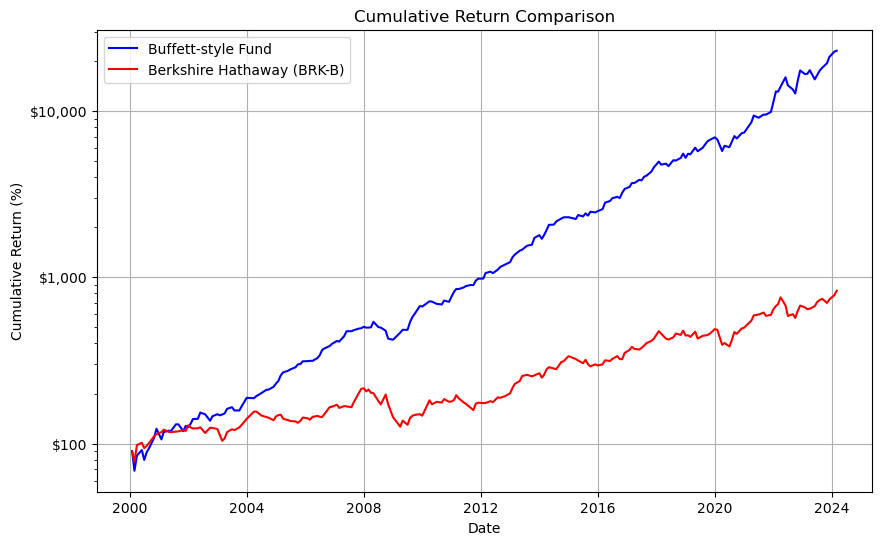

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# Assuming df contains the DataFrame with columns 'Date', 'R_Buffett_Style', and 'BRK-A'

# Calculate cumulative returns
df['Cumulative_Return_Buffett'] = (1 + df['R_Buffett_Style']).cumprod() * 100
df['Cumulative_Return_BRK-B'] = (1 + df['BRK-B Risk Premium']).cumprod() * 100

# Formatter function to display y-axis ticks in dollar format
def format_dollars(x, pos):
    return f'${x:,.0f}'

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Cumulative_Return_Buffett'], label='Buffett-style Fund', color='blue')
plt.plot(df['Date'], df['Cumulative_Return_BRK-B'], label='Berkshire Hathaway (BRK-B)', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Return Comparison')
plt.legend()
plt.grid(True)

# Set y-axis to logarithmic scale
plt.yscale('log')

# Apply the dollar formatting to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_dollars))

plt.show()


The plot above, showing the cumulated returns of the Buffett-style portfolio VS Berkshire, pictures a clear outperformance of our strategy with respect to Berkshire. However, such a weird behaviour was expected (as discussed both in the Paper by FKP and in class), and is due to the so-called *look-ahead bias*, which refers to the incorporation of information that would not have been available or known at the time of making a decision or conducting an analysis.

# Task 8
Run regressions of Berkshire on the systematic portfolio and of the systematic portfolio on
Berkshire (as in the table in the slides I prepared and discussed in class).

In [21]:
df.head()

,Date,BAB Factors,MKT,SMB,HML FF,UMD,RF,QMJ Factors,BRK-B Returns,BRK-B Risk Premium,Active_Returns,Rt_Active,Rt_Active_Adjusted,R_Buffett_Style
1,2000-01-31,-0.002048,-0.042145,0.050176,-0.000573,0.012701,0.004308,-0.027291,-0.100546,-0.104855,-0.079470,-0.035289,-0.081735,-0.098503
2,2000-02-29,-0.134174,0.027377,0.127406,-0.084274,0.170105,0.004608,-0.066672,-0.125152,-0.129760,-0.138843,-0.110421,-0.255756,-0.237457
3,2000-03-31,0.001288,0.053077,-0.097396,0.013317,-0.049388,0.004683,0.045559,0.263889,0.259206,0.237346,0.087365,0.202355,0.233581
4,2000-05-31,0.060508,-0.045907,-0.043369,0.028036,-0.072868,0.004717,0.030251,0.036264,0.031547,0.059222,0.042161,0.097652,0.079411
5,2000-06-30,-0.101337,0.047920,0.080917,-0.078898,0.142324,0.004567,-0.028912,-0.066808,-0.071375,-0.090772,-0.067670,-0.156737,-0.128206


In [25]:
# Define the dependent and independent variables for both regressions
# Regression of BRK-B on R_Buffett_Style
Y_brk_on_buffett = df['BRK-B Risk Premium']
X_brk_on_buffett = sm.add_constant(df['R_Buffett_Style'])  # Adds a constant term to the predictor

# Regression of R_Buffett_Style on BRK-B
Y_buffett_on_brk = df['R_Buffett_Style']
X_buffett_on_brk = sm.add_constant(df['BRK-B Risk Premium'])

# Perform the regressions
model_brk_on_buffett = sm.OLS(Y_brk_on_buffett, X_brk_on_buffett).fit()
model_buffett_on_brk = sm.OLS(Y_buffett_on_brk, X_buffett_on_brk).fit()

# Summarize the results
results_brk_on_buffett = model_brk_on_buffett.summary()
results_buffett_on_brk = model_buffett_on_brk.summary()
print(results_brk_on_buffett)

                            OLS Regression Results                            
Dep. Variable:     BRK-B Risk Premium   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     77.39
Date:                Fri, 03 May 2024   Prob (F-statistic):           5.95e-16
Time:                        18:24:08   Log-Likelihood:                 322.10
No. Observations:                 206   AIC:                            -640.2
Df Residuals:                     204   BIC:                            -633.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0029      0.004     

In [26]:
print(results_buffett_on_brk)

                            OLS Regression Results                            
Dep. Variable:        R_Buffett_Style   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     77.39
Date:                Fri, 03 May 2024   Prob (F-statistic):           5.95e-16
Time:                        18:24:08   Log-Likelihood:                 322.72
No. Observations:                 206   AIC:                            -641.4
Df Residuals:                     204   BIC:                            -634.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0222      0

The two regression summaries above show that the two models share the exact same regression R^2, the latter indicating the variability explained by the model, and even an almost identical beta. The alpha of both models is close to 0, even though the one of the first model is not statistically significant (since pvalue is too high). 

Finally, we conclude stating that the mimicking strategy we implemented exactly matches Berkshire's:

- beta
- idiosyncratic volatility
- total volatility
- relative active loadings